## Data / Package Import 

In [1]:
import pandas as pd
import os
from Bio import Affy
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, GRU, Layer, Add, GlobalAveragePooling1D, Conv1D, ReLU
from sklearn.model_selection import KFold, cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Dense, Dropout, Activation, LeakyReLU, Reshape
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, cross_val_score
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Lambda
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from hyperopt.pyll.base import scope
import scipy.stats as stats
from keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras import backend as K
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from accelerate import DataLoaderConfiguration
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.regularizers import l1
from bayes_opt import BayesianOptimization
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from boruta import BorutaPy
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from boruta import BorutaPy
from skrebate import ReliefF
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.svm import SVC

C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## AMGM and Cosine Feature Selection

In [2]:
def calculate_amgm(X):
    """
    Calculate AMGM for each feature (row) in the dataset X.
    
    Parameters:
    X (numpy array): The input data array with shape (n_features, n_samples)
    
    Returns:
    amgm_values (numpy array): The AMGM values for each feature (row)
    """
    N = X.shape[1]
    
    exp_X = np.exp(X)
    amgm_values = (np.mean(exp_X, axis=1)) / (np.exp(np.mean(X, axis=1)))
    
    return amgm_values

In [3]:
def filter_redundant_features(X, relevant_indices, threshold=0.9):
    relevant_features = X[relevant_indices, :]
    cos_sim_matrix = cosine_similarity(relevant_features)
    
    to_keep = []
    to_drop = set()
    for i in range(cos_sim_matrix.shape[0]):
        if i not in to_drop:
            to_keep.append(relevant_indices[i])
            for j in range(i + 1, cos_sim_matrix.shape[0]):
                if cos_sim_matrix[i, j] > threshold:
                    to_drop.add(relevant_indices[j])
    return to_keep

## Autoencoder Feature Selection with Lasso Regression

In [138]:
def create_feature_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)  # Encoder part
    decoded = Dense(input_dim, activation='sigmoid')(encoded)  # Decoder part
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

In [139]:
def apply_l1_feature_selection(X, y, alpha=0.01, target_features=100):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    model = SelectFromModel(lasso, prefit=True, max_features=target_features)
    X_reduced = model.transform(X)
    selected_indices = model.get_support(indices=True)
    return X_reduced, selected_indices

## Initial Deep Autoencoder

In [31]:
def create_deep_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(input_dim // 2, input_shape=(input_dim,), activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 4, activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 2, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(3, activation='softmax'))  # Final classification layer with 3 units
    return model

In [32]:
def cyclical_learning_rate(epoch, lr):
    base_lr = 0.001
    max_lr = 0.006
    step_size = 2000
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

In [10]:
input_file_path = 'C:/Research_Summer/FinalizedSmokingData.csv' #Change for different files

In [16]:
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]  # SNP genotype data
case_control_info = df.iloc[-1, :]  # Case/Control row

C:\Users\colte\AppData\Local\Temp\ipykernel_12496\562430524.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [17]:
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [18]:
amgm_values = calculate_amgm(X)

In [19]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [20]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [332655 237829 360869 353554 301834 174984 301209 373329 254831 199130]
Top AMGM values: [1.01722519 1.01722697 1.01723428 1.01723428 1.01723589 1.0172371
 1.0172371  1.0172371  1.0172371  1.01724378]


In [21]:
y = case_control_info.map({'Healthy Non Smoker': 0, 'Healthy Smoker': 1, 'Non Healthy Smoker': 2}).values

In [22]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [23]:
X_selected = X[selected_indices, :].T 

In [24]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [35]:
y_train_encoded = to_categorical(y_train, num_classes=3)
y_val_encoded = to_categorical(y_val, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

In [36]:
input_dim = X_train.shape[1]
model = create_deep_autoencoder(input_dim)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           1,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,826 (50.10 KB)

 Trainable params: 12,826 (50.10 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
clr = LearningRateScheduler(cyclical_learning_rate)
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_val, y_val_encoded), callbacks=[clr])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.4297 - loss: 1.0702 - val_accuracy: 0.5833 - val_loss: 0.9856 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5750 - loss: 0.8898 - val_accuracy: 0.5833 - val_loss: 1.0686 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6148 - loss: 0.9156 - val_accuracy: 0.5833 - val_loss: 1.1472 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5914 - loss: 0.9320 - val_accuracy: 0.5833 - val_loss: 1.1317 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5945 - loss: 0.7722 - val_accuracy: 0.5833 - val_loss: 1.1417 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5266 - loss: 0.9264 - val_accuracy: 0.5833 - val_loss: 1.1403 - learning_rate: 0.0010
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5641 - loss: 0.8395 - val_accuracy: 0.5833 

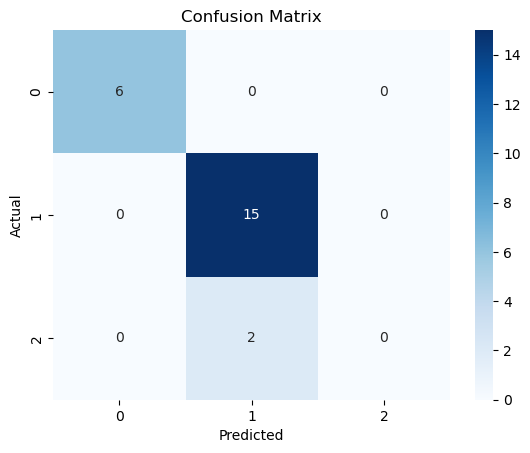

In [43]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [44]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test_encoded, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred)
f1 = f1_score(y_test_labels, y_pred, average='weighted')  # Use 'weighted' for multi-class f1 score

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

for i in range(3):  # Assuming 3 classes
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp
    fp = cm[:, i].sum() - tp
    tn = cm.sum() - (tp + fn + fp)
    
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    
    print(f"Class {i} - Sensitivity: {sensitivity}, Specificity: {specificity}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Accuracy: 0.9130434782608695
F1 Score: 0.8722826086956522
Class 0 - Sensitivity: 1.0, Specificity: 1.0
Class 1 - Sensitivity: 1.0, Specificity: 0.75
Class 2 - Sensitivity: 0.0, Specificity: 1.0


## Deep Autoencoder with Optimized Hyperparameters (Bayesian Optimization)

In [45]:
input_file_path = 'C:/Research_Summer/FinalizedSmokingData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_12496\2537731385.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [46]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [47]:
amgm_values = calculate_amgm(X)

In [48]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [49]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [332655 237829 360869 353554 301834 174984 301209 373329 254831 199130]
Top AMGM values: [1.01722519 1.01722697 1.01723428 1.01723428 1.01723589 1.0172371
 1.0172371  1.0172371  1.0172371  1.01724378]


In [50]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [51]:
X_selected = X[selected_indices, :].T

In [52]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [53]:
y = case_control_info.map({'Healthy Non Smoker': 0, 'Healthy Smoker': 1, 'Non Healthy Smoker': 2}).values

In [63]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [54]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(3, activation='softmax'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [55]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [56]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_selected.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_selected, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
    conf_matrix = confusion_matrix(y, y_pred)
    sensitivity = np.mean([conf_matrix[i, i] / (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) if (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) != 0 else 0 for i in range(3)])
    specificity = np.mean([np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1)) / (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) if (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) != 0 else 0 for i in range(3)])

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}


In [57]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:5 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001A287945260> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Accuracy: 0.8956521739130435, F1 Score: 0.8634713645340272, Sensitivity: 0.6433719433719434, Specificity: 9.666666666666666
Accuracy: 0.6086956521739131, F

In [58]:
print("Best parameters found: ", best)
best_trial = min(trials.results, key=lambda x: x['loss'])
print(f"Best Accuracy: {best_trial['accuracy']}")
print(f"Best F1 Score: {-best_trial['loss']}")
print(f"Best Specificity: {best_trial['specificity']}")
print(f"Best Sensitivity: {best_trial['sensitivity']}")

Best parameters found:  {'batch_size': 112.0, 'dropout_rate': 0.496820637170488, 'epochs': 100.0, 'learning_rate': 0.0007377012059636542, 'neurons1': 160.0, 'neurons2': 96.0}
Best Accuracy: 0.9826086956521739
Best F1 Score: 0.9827115046595696
Best Specificity: 12.666666666666666
Best Sensitivity: 0.9904761904761905


In [59]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

In [64]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Ensure all data is cast to float32
        X_train = X_train.astype(np.float32)
        X_val = X_val.astype(np.float32)
        
        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        model = create_deep_autoencoder(
            input_dim=X_train.shape[1],
            neurons1=best_params['neurons1'],
            neurons2=best_params['neurons2'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )

        model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for the current fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)

    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nCross-Validation Performance:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average F1 Score: {avg_f1}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

In [65]:
train_and_evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

Cross-Validation Performance:
Average Accuracy: 0.9913043478260869
Average F1 Score: 0.9915593522886651
Average Sensitivity: 0.9958333333333332
Average Specificity: 0.9962962962962962


In [66]:
print("\nBest Hyperparameters:")
print(f"Neurons in first layer: {int(best['neurons1'])}")
print(f"Neurons in second layer: {int(best['neurons2'])}")
print(f"Dropout rate: {best['dropout_rate']}")
print(f"Learning rate: {best['learning_rate']}")
print(f"Number of epochs: {int(best['epochs'])}")
print(f"Batch size: {int(best['batch_size'])}")


Best Hyperparameters:
Neurons in first layer: 160
Neurons in second layer: 96
Dropout rate: 0.496820637170488
Learning rate: 0.0007377012059636542
Number of epochs: 100
Batch size: 112


## CNN with Bayesian Optimization

In [105]:
input_file_path = 'C:/Research_Summer/FinalizedSmokingData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_12496\2537731385.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [106]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Healthy Non Smoker': 0, 'Healthy Smoker': 1, 'Non Healthy Smoker': 2}).values
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [107]:
amgm_values = calculate_amgm(X)

In [108]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [109]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [110]:
X_selected = X[selected_indices, :].T

In [111]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [112]:
X_selected = X_selected.reshape(X_selected.shape[0], X_selected.shape[1], 1)  # Add a channel dimension

In [113]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [114]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001, num_classes=3):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [115]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [116]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [117]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            num_classes=3
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [118]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step                                               
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step                                              

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step                                               
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step                                              

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step                                               
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step                                              

Iteration Results - Accuracy: 0.5318996415770609, F1 Score: 0.5239145561726207, Sensitivity: 0.603638726445744, Specificity: 0.8010290475807719
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step                                               
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step                                              

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step                                               
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step                                            

In [119]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 16, 'dropout_rate': 0.31270726017334977, 'epochs': 40, 'filters': 96, 'kernel_size': 3, 'learning_rate': 0.00483393068727293}


In [ ]:
def k_fold_cross_validation(X, y, best_params, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_index, val_index in kfold.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        input_dim = X_train.shape[1]
        model = create_cnn_model(
            input_shape=(input_dim, 1),
            filters=best_params['filters'],
            kernel_size=best_params['kernel_size'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate'],
            num_classes=3
        )
        model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    print(f"Avg Accuracy: {avg_accuracy}")
    print(f"Avg F1 Score: {avg_f1}")
    print(f"Avg Sensitivity: {avg_sensitivity}")
    print(f"Avg Specificity: {avg_specificity}")

    return avg_accuracy, avg_f1, avg_sensitivity, avg_specificity

In [ ]:
avg_accuracy, avg_f1, avg_sensitivity, avg_specificity = k_fold_cross_validation(X_selected, y, best_params, n_splits=5)

## FNN with Bayesian Optimization

In [128]:
input_file_path = 'C:/Research_Summer/FinalizedSmokingData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Healthy Non Smoker': 0, 'Healthy Smoker': 1, 'Non Healthy Smoker': 2}).values
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

C:\Users\colte\AppData\Local\Temp\ipykernel_12496\2654263825.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [129]:
amgm_values = calculate_amgm(X)
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [130]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 
X_selected = X[selected_indices, :].T
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)
X_selected = X_selected.reshape((X_selected.shape[0], X_selected.shape[1], 1))

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [132]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [133]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [134]:
def objective(params):
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [135]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 0.8467203974723816, Params: {'batch_size': 64, 'dropout_rate': 0.14550150877623766, 'epochs': 60, 'learning_rate': 4.193895236504536e-05, 'num_layers': 4, 'units': 224}
Iteration - Loss: 0.03029010258615017, Params: {'batch_size': 32, 'dropout_rate': 0.4691658292645793, 'epochs': 120, 'learning_rate': 0.0007580449098404, 'num_layers': 3, 'units': 96}
Iteration - Loss: 0.6548975110054016, Params: {'batch_size': 96, 'dropout_rate': 0.4380097988084769, 'epochs': 80, 'learning_rate': 0.00015355143685049125, 'num_layers': 2, 'units': 224}
Iteration - Loss: 1.0490143299102783, Params: {'batch_size': 80, 'dropout_rate': 0.4658992048889006, 'epochs': 80, 'learning_rate': 1.3003778487426589e-05, 'num_layers': 4, 'units': 128}
Iteration - Loss: 0.4232993721961975, Params: {'batch_size': 96, 'dropout_rate': 0.24956227333735212, 'epochs': 50, 'learning_rate': 0.00023896664759154448, 'num_layers': 5, 'units': 224}
Iteration - Loss: 0.7524998188018799, Params: {'batch_size': 80, 'd

In [136]:
best_params = {
    'num_layers': int(best['num_layers']),
    'units': int(best['units']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'num_layers': 3, 'units': 192, 'dropout_rate': 0.4101231142007279, 'learning_rate': 0.005492548344129689, 'epochs': 130, 'batch_size': 16}


In [137]:
def evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = create_fnn_model(
            input_dim=X_train.shape[1],
            num_layers=best_params['num_layers'],
            units=best_params['units'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nFinal Model Performance with K-Fold Cross-Validation:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Final Model Performance with K-Fold Cross-Validation:
Accuracy: 0.9565217391304348
F1 Score: 0.9513487275501007
Sensitivity: 0.8846445221445223
Specificity: 0.9702157102157102


## Stacked Autoencoder & FNN Model

In [141]:
input_file_path = 'C:/Research_Summer/FinalizedSmokingData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]
case_control_info = df.iloc[-1, :]
y = case_control_info.map({'Healthy Non Smoker': 0, 'Healthy Smoker': 1, 'Non Healthy Smoker': 2}).values.astype(np.float32)
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)

C:\Users\colte\AppData\Local\Temp\ipykernel_12496\1098725791.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [142]:
amgm_values = calculate_amgm(X)
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [332655 237829 301834 360869 353554 373329 301209 254831 174984 199130]
Top AMGM values: [1.0172246 1.0172266 1.0172347 1.0172356 1.0172356 1.0172372 1.0172372
 1.0172373 1.0172374 1.017245 ]


In [143]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 
X_selected = X[selected_indices, :].T
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)
def ensure_float32(data):
    return data.astype(np.float32)

In [144]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [145]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [146]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate, num_classes):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [147]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [148]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0,
        num_classes=3  # Set to the number of classes
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [149]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [150]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step            

In [151]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate'],
            num_classes=3  # Set to the number of classes
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val)
        y_val_pred_binary = np.argmax(y_val_pred, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred_binary, num_classes=3)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")


In [152]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Final Model - Accuracy: 0.9245614035087719
Final Model - F1 Score: 0.903074438232333
Final Model - Sensitivity: 0.6856060606060606
Final Model - Specificity: 0.9412938912938913


## Deep Autoencoder with L1 Feature Selection

In [153]:
def create_deep_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(input_dim // 2, input_shape=(input_dim,), activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 4, activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 2, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(3, activation='softmax'))  # Final classification layer with 3 units
    return model

In [154]:
def cyclical_learning_rate(epoch, lr):
    base_lr = 0.001
    max_lr = 0.006
    step_size = 2000
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

In [155]:
input_file_path = 'C:/Research_Summer/FinalizedSmokingData.csv' #Change for different files

In [156]:
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]  # SNP genotype data
case_control_info = df.iloc[-1, :]  # Case/Control row

C:\Users\colte\AppData\Local\Temp\ipykernel_12496\562430524.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [157]:
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [158]:
y = case_control_info.map({'Healthy Non Smoker': 0, 'Healthy Smoker': 1, 'Non Healthy Smoker': 2}).values

In [159]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [160]:
X_scaled = X_scaled.T

In [161]:
input_dim = X_scaled.shape[1]
encoding_dim = 1000

In [162]:
autoencoder, encoder = create_feature_autoencoder(input_dim, encoding_dim)
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 1.2503 - val_loss: 1.2306
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.2309 - val_loss: 1.1382
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 1.0281 - val_loss: 1.0256
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.9879 - val_loss: 1.0118
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.9880 - val_loss: 1.0142
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.9906 - val_loss: 1.0151
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.9907 - val_loss: 1.0149
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.9895 - val_loss: 1.0146
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.9879 - val_loss: 1.0143
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.9861 - val_loss: 1.0139
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.9842 - val_loss: 1.0136
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.9822 - val_loss: 1.0134
Epoch 13/50
1/1 ━━━━━━━━━

In [163]:
X_encoded = encoder.predict(X_scaled)
print(f"Shape of encoded features: {X_encoded.shape}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step
Shape of encoded features: (115, 1000)


In [164]:
target_features = 200  # Target number of features
X_final, selected_indices_l1 = apply_l1_feature_selection(X_encoded, y, alpha=0.005, target_features=target_features)
print(f"Shape after L1-based Feature Selection: {X_final.shape}")

Shape after L1-based Feature Selection: (115, 200)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.322e-01, tolerance: 3.769e-03
  model = cd_fast.enet_coordinate_descent(


In [165]:
X_final.shape

(115, 200)

In [167]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [168]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

In [173]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [174]:
y_train_encoded = to_categorical(y_train, num_classes=3)
y_val_encoded = to_categorical(y_val, num_classes=3)
y_test_encoded = to_categorical(y_test, num_classes=3)

In [175]:
input_dim = X_train.shape[1]
model = create_deep_autoencoder(input_dim)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [176]:
model.summary()

Model: "sequential_214"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1485 (Dense)                   │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_747 (Dropout)                │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1486 (Dense)                   │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_748 (Dropout)                │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1487 (Dense)                   │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1488 (Dense)                   │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1489 (Dense)                   │ (None, 3)                   │             603 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 51,053 (199.43 KB)

 Trainable params: 51,053 (199.43 KB)

 Non-trainable params: 0 (0.00 B)

In [177]:
clr = LearningRateScheduler(cyclical_learning_rate)
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_val, y_val_encoded), callbacks=[clr])

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.4672 - loss: 1.0208 - val_accuracy: 0.5833 - val_loss: 1.1366 - learning_rate: 0.0010
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6594 - loss: 0.9330 - val_accuracy: 0.5833 - val_loss: 1.2936 - learning_rate: 0.0010
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6375 - loss: 0.8046 - val_accuracy: 0.2500 - val_loss: 1.4001 - learning_rate: 0.0010
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5063 - loss: 1.0794 - val_accuracy: 0.2500 - val_loss: 1.3584 - learning_rate: 0.0010
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4437 - loss: 0.9779 - val_accuracy: 0.5833 - val_loss: 1.1714 - learning_rate: 0.0010
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5906 - loss: 0.8472 - val_accuracy: 0.5833 - val_loss: 1.0712 - learning_rate: 0.0010
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6062 - loss: 0.8460 - val_accuracy: 0.5833

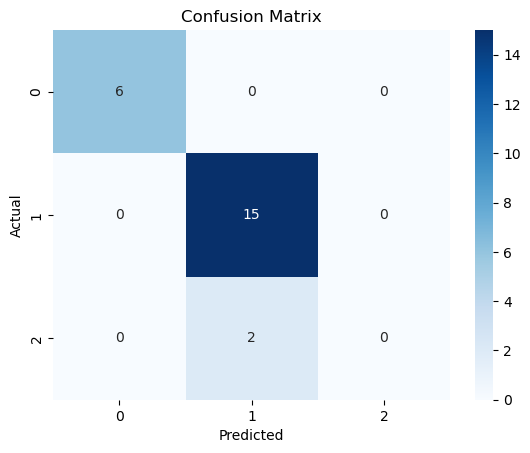

In [178]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [179]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test_encoded, axis=1)

accuracy = accuracy_score(y_test_labels, y_pred)
f1 = f1_score(y_test_labels, y_pred, average='weighted')  # Use 'weighted' for multi-class f1 score

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

for i in range(3):  # Assuming 3 classes
    tp = cm[i, i]
    fn = cm[i, :].sum() - tp
    fp = cm[:, i].sum() - tp
    tn = cm.sum() - (tp + fn + fp)
    
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    
    print(f"Class {i} - Sensitivity: {sensitivity}, Specificity: {specificity}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Accuracy: 0.8260869565217391
F1 Score: 0.7888198757763975
Class 0 - Sensitivity: 1.0, Specificity: 1.0
Class 1 - Sensitivity: 1.0, Specificity: 0.75
Class 2 - Sensitivity: 0.0, Specificity: 1.0


## Deep Autoencoder with Optimized Hyperparameters (Bayesian Optimization) - L1 Feature Selection

In [181]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(3, activation='softmax'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [180]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [182]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

In [183]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [184]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_selected.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_selected, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
    conf_matrix = confusion_matrix(y, y_pred)
    sensitivity = np.mean([conf_matrix[i, i] / (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) if (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) != 0 else 0 for i in range(3)])
    specificity = np.mean([np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1)) / (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) if (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) != 0 else 0 for i in range(3)])

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}


In [185]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

print("Best parameters found: ", best)

Accuracy: 0.6347826086956522, F1 Score: 0.5279503105590063, Sensitivity: 0.3646074646074646, Specificity: 25.69918699186992
Accuracy: 0.9739130434782609, F1 Score: 0.9741356073314182, Sensitivity: 0.9857142857142858, Specificity: 8.333333333333334
Accuracy: 0.7565217391304347, F1 Score: 0.7179817498658078, Sensitivity: 0.4992277992277992, Specificity: 8.6          
Accuracy: 0.8869565217391304, F1 Score: 0.8892223219946767, Sensitivity: 0.8273809523809524, Specificity: 16.333333333333332
Accuracy: 0.6086956521739131, F1 Score: 0.46063454759106937, Sensitivity: 0.3333333333333333, Specificity: 0.0         
Accuracy: 0.9565217391304348, F1 Score: 0.9556312939484662, Sensitivity: 0.9023809523809524, Specificity: 15.5         
Accuracy: 0.8260869565217391, F1 Score: 0.7930586130985141, Sensitivity: 0.5628056628056628, Specificity: 26.12280701754386
Accuracy: 0.6086956521739131, F1 Score: 0.46063454759106937, Sensitivity: 0.3333333333333333, Specificity: 0.0         
Accuracy: 0.87826086956

In [186]:
print("Best parameters found: ", best)
best_trial = min(trials.results, key=lambda x: x['loss'])
print(f"Best Accuracy: {best_trial['accuracy']}")
print(f"Best F1 Score: {-best_trial['loss']}")
print(f"Best Specificity: {best_trial['specificity']}")
print(f"Best Sensitivity: {best_trial['sensitivity']}")

Best parameters found:  {'batch_size': 128.0, 'dropout_rate': 0.3944962522091393, 'epochs': 150.0, 'learning_rate': 0.0009211696392887577, 'neurons1': 224.0, 'neurons2': 128.0}
Best Accuracy: 0.991304347826087
Best F1 Score: 0.9913310395162132
Best Specificity: 25.666666666666668
Best Sensitivity: 0.9952380952380953


In [190]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

In [191]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Ensure all data is cast to float32
        X_train = X_train.astype(np.float32)
        X_val = X_val.astype(np.float32)
        
        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        model = create_deep_autoencoder(
            input_dim=X_train.shape[1],
            neurons1=best_params['neurons1'],
            neurons2=best_params['neurons2'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )

        model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for the current fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)

    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nCross-Validation Performance:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average F1 Score: {avg_f1}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

In [192]:
train_and_evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

Cross-Validation Performance:
Average Accuracy: 0.9826086956521738
Average F1 Score: 0.9828239030796311
Average Sensitivity: 0.9891666666666665
Average Specificity: 0.9907407407407408


## CNN with Bayesian Optimization - L1 Feature Selection

In [193]:
X_selected = X_final.reshape(X_final.shape[0], X_final.shape[1], 1)  # Add a channel dimension

In [194]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [195]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001, num_classes=3):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [196]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [197]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            num_classes=3
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [198]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step                                               
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step                                              

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step                                               
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step                                              

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step                                               
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step                                              

Iteration Results - Accuracy: 0.5673835125448029, F1 Score: 0.5357707366309518, Sensitivity: 0.39955106621773284, Specificity: 0.7186905686905688
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step                                               
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step                                              

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step                                               
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step                                          

In [199]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.4324607994680786, 'epochs': 40, 'filters': 96, 'kernel_size': 3, 'learning_rate': 0.0014827653002450546}


In [ ]:
def k_fold_cross_validation(X, y, best_params, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_index, val_index in kfold.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        input_dim = X_train.shape[1]
        model = create_cnn_model(
            input_shape=(input_dim, 1),
            filters=best_params['filters'],
            kernel_size=best_params['kernel_size'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate'],
            num_classes=3
        )
        model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    print(f"Avg Accuracy: {avg_accuracy}")
    print(f"Avg F1 Score: {avg_f1}")
    print(f"Avg Sensitivity: {avg_sensitivity}")
    print(f"Avg Specificity: {avg_specificity}")

    return avg_accuracy, avg_f1, avg_sensitivity, avg_specificity

In [ ]:
avg_accuracy, avg_f1, avg_sensitivity, avg_specificity = k_fold_cross_validation(X_selected, y, best_params, n_splits=5)

## FNN with Bayesian Optimization - L1 Feature Selection

In [204]:
X_selected = X_final.reshape((X_final.shape[0], X_final.shape[1], 1))

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [206]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [207]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [208]:
def objective(params):
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [209]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 7.598592281341553, Params: {'batch_size': 80, 'dropout_rate': 0.36291639008943266, 'epochs': 120, 'learning_rate': 0.0008239269441370041, 'num_layers': 4, 'units': 192}
Iteration - Loss: 1.2939319610595703, Params: {'batch_size': 64, 'dropout_rate': 0.21741970214821404, 'epochs': 80, 'learning_rate': 0.0043466524493786275, 'num_layers': 5, 'units': 64}
Iteration - Loss: 12.373751640319824, Params: {'batch_size': 80, 'dropout_rate': 0.21182244722058508, 'epochs': 100, 'learning_rate': 0.0010664765697539328, 'num_layers': 3, 'units': 96}
Iteration - Loss: 8.703193664550781, Params: {'batch_size': 112, 'dropout_rate': 0.4763164246362537, 'epochs': 50, 'learning_rate': 4.9809582527876526e-05, 'num_layers': 2, 'units': 256}
Iteration - Loss: 2.1435766220092773, Params: {'batch_size': 64, 'dropout_rate': 0.18468778359643268, 'epochs': 70, 'learning_rate': 0.0009838251245606702, 'num_layers': 3, 'units': 224}
Iteration - Loss: 11.130777359008789, Params: {'batch_size': 80, '

In [210]:
best_params = {
    'num_layers': int(best['num_layers']),
    'units': int(best['units']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'num_layers': 3, 'units': 224, 'dropout_rate': 0.10526152591122338, 'learning_rate': 0.0004811635097023447, 'epochs': 70, 'batch_size': 32}


In [211]:
def evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = create_fnn_model(
            input_dim=X_train.shape[1],
            num_layers=best_params['num_layers'],
            units=best_params['units'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nFinal Model Performance with K-Fold Cross-Validation:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

Final Model Performance with K-Fold Cross-Validation:
Accuracy: 0.7304347826086957
F1 Score: 0.7126906941102928
Sensitivity: 0.5631358456358456
Specificity: 0.8080704589528119


## Stacked Autoencoder & FNN Model - L1 Feature Selection

In [224]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [225]:
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [226]:
def ensure_float32(data):
    return data.astype(np.float32)

In [232]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [233]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [234]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate, num_classes):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [235]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0,
        num_classes=3  # Set to the number of classes
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [236]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [237]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step            

In [240]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate'],
            num_classes=3  # Set to the number of classes
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val)
        y_val_pred_binary = np.argmax(y_val_pred, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred_binary, num_classes=3)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")


In [241]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Final Model - Accuracy: 0.564327485380117
Final Model - F1 Score: 0.5529356725146198
Final Model - Sensitivity: 0.4157070707070707
Final Model - Specificity: 0.7057239057239058


## Deep Autoencoder with Optimized Hyperparameters (Bayesian Optimization) - 1500 SNPs

In [242]:
input_file_path = 'C:/Research_Summer/FinalizedSmokingData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_12496\2537731385.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [247]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [248]:
amgm_values = calculate_amgm(X)

In [249]:
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [250]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [ 42116 274895 244136 247656  54697  57708 171483  47906 415648 112210]
Top AMGM values: [1.01091414 1.01091455 1.01091503 1.01091503 1.01091503 1.01091503
 1.01091503 1.01091503 1.01091503 1.01091503]


In [251]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1500] 

In [252]:
X_selected = X[selected_indices, :].T

In [253]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [254]:
y = case_control_info.map({'Healthy Non Smoker': 0, 'Healthy Smoker': 1, 'Non Healthy Smoker': 2}).values

In [255]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [256]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(3, activation='softmax'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [257]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [258]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_selected.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_selected, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
    conf_matrix = confusion_matrix(y, y_pred)
    sensitivity = np.mean([conf_matrix[i, i] / (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) if (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) != 0 else 0 for i in range(3)])
    specificity = np.mean([np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1)) / (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) if (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) != 0 else 0 for i in range(3)])

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}


In [259]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

Accuracy: 0.9304347826086956, F1 Score: 0.8990455991516437, Sensitivity: 0.6666666666666666, Specificity: 2.9166666666666665
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 0.0                                                       
Accuracy: 0.9304347826086956, F1 Score: 0.8990455991516437, Sensitivity: 0.6666666666666666, Specificity: 2.9166666666666665
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 0.0                                                       
Accuracy: 0.9826086956521739, F1 Score: 0.9815952925792744, Sensitivity: 0.9166666666666666, Specificity: 12.666666666666666
Accuracy: 0.5739130434782609, F1 Score: 0.573619300632843, Sensitivity: 0.4616151866151867, Specificity: 1.2094017094017095
Accuracy: 0.9304347826086956, F1 Score: 0.8990455991516437, Sensitivity: 0.6666666666666666, Specificity: 2.9166666666666665
Accuracy: 0.991304347826087, F1 Score: 0.9913310395162132, Sensitivity: 0.9952380952380953, Specificity: 25.666666666666668
Accuracy: 0.

In [260]:
print("Best parameters found: ", best)
best_trial = min(trials.results, key=lambda x: x['loss'])
print(f"Best Accuracy: {best_trial['accuracy']}")
print(f"Best F1 Score: {-best_trial['loss']}")
print(f"Best Specificity: {best_trial['specificity']}")
print(f"Best Sensitivity: {best_trial['sensitivity']}")

Best parameters found:  {'batch_size': 112.0, 'dropout_rate': 0.42604577158372325, 'epochs': 150.0, 'learning_rate': 0.0042749089864200455, 'neurons1': 128.0, 'neurons2': 32.0}
Best Accuracy: 1.0
Best F1 Score: 1.0
Best Specificity: 0.0
Best Sensitivity: 1.0


In [261]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

In [262]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Ensure all data is cast to float32
        X_train = X_train.astype(np.float32)
        X_val = X_val.astype(np.float32)
        
        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        model = create_deep_autoencoder(
            input_dim=X_train.shape[1],
            neurons1=best_params['neurons1'],
            neurons2=best_params['neurons2'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )

        model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for the current fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)

    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nCross-Validation Performance:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average F1 Score: {avg_f1}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

In [263]:
train_and_evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

Cross-Validation Performance:
Average Accuracy: 0.9391304347826086
Average F1 Score: 0.9133527302005563
Average Sensitivity: 0.7
Average Specificity: 0.9473626373626374


In [264]:
print("\nBest Hyperparameters:")
print(f"Neurons in first layer: {int(best['neurons1'])}")
print(f"Neurons in second layer: {int(best['neurons2'])}")
print(f"Dropout rate: {best['dropout_rate']}")
print(f"Learning rate: {best['learning_rate']}")
print(f"Number of epochs: {int(best['epochs'])}")
print(f"Batch size: {int(best['batch_size'])}")


Best Hyperparameters:
Neurons in first layer: 128
Neurons in second layer: 32
Dropout rate: 0.42604577158372325
Learning rate: 0.0042749089864200455
Number of epochs: 150
Batch size: 112


## CNN with Bayesian Optimization - 1500 SNPs

In [265]:
input_file_path = 'C:/Research_Summer/FinalizedSmokingData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_12496\2537731385.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [266]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Healthy Non Smoker': 0, 'Healthy Smoker': 1, 'Non Healthy Smoker': 2}).values
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [267]:
amgm_values = calculate_amgm(X)

In [268]:
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [269]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1500] 

In [270]:
X_selected = X[selected_indices, :].T

In [271]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [272]:
X_selected = X_selected.reshape(X_selected.shape[0], X_selected.shape[1], 1)  # Add a channel dimension

In [273]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [274]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001, num_classes=3):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [275]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [276]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [277]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            num_classes=3
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [278]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step                                               
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step                                              

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step                                               
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step                                              

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step                                               
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step                                              

Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step                                               
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step                                              

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step                                               
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step                                              

1/1 ━━━━━━━━━━━━━━━━

In [285]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 16, 'dropout_rate': 0.26742747131047984, 'epochs': 30, 'filters': 96, 'kernel_size': 4, 'learning_rate': 0.002429338523030006}


In [ ]:
def k_fold_cross_validation(X, y, best_params, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_index, val_index in kfold.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        input_dim = X_train.shape[1]
        model = create_cnn_model(
            input_shape=(input_dim, 1),
            filters=best_params['filters'],
            kernel_size=best_params['kernel_size'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate'],
            num_classes=3
        )
        model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_val, y_val), callbacks=[early_stopping], verbose=0)

        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    print(f"Avg Accuracy: {avg_accuracy}")
    print(f"Avg F1 Score: {avg_f1}")
    print(f"Avg Sensitivity: {avg_sensitivity}")
    print(f"Avg Specificity: {avg_specificity}")

    return avg_accuracy, avg_f1, avg_sensitivity, avg_specificity

In [ ]:
avg_accuracy, avg_f1, avg_sensitivity, avg_specificity = k_fold_cross_validation(X_selected, y, best_params, n_splits=5)

## FNN with Bayesian Optimization - 1500 SNPs

In [292]:
input_file_path = 'C:/Research_Summer/FinalizedSmokingData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Healthy Non Smoker': 0, 'Healthy Smoker': 1, 'Non Healthy Smoker': 2}).values
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

C:\Users\colte\AppData\Local\Temp\ipykernel_12496\2654263825.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [293]:
amgm_values = calculate_amgm(X)
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [294]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1500] 
X_selected = X[selected_indices, :].T
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)


In [295]:
X_selected = X_selected.reshape((X_selected.shape[0], X_selected.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [296]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [297]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [298]:
def objective(params):
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [299]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 0.38979142904281616, Params: {'batch_size': 16, 'dropout_rate': 0.47377224347318936, 'epochs': 50, 'learning_rate': 4.205635697544648e-05, 'num_layers': 2, 'units': 128}
Iteration - Loss: 0.018770117312669754, Params: {'batch_size': 112, 'dropout_rate': 0.48134313013219254, 'epochs': 110, 'learning_rate': 0.009601182800474067, 'num_layers': 5, 'units': 96}
Iteration - Loss: 0.7532141804695129, Params: {'batch_size': 112, 'dropout_rate': 0.2714051111483433, 'epochs': 100, 'learning_rate': 5.930660066242964e-05, 'num_layers': 6, 'units': 192}
Iteration - Loss: 0.918735146522522, Params: {'batch_size': 64, 'dropout_rate': 0.44308344065907923, 'epochs': 110, 'learning_rate': 0.0003827845464477543, 'num_layers': 5, 'units': 96}
Iteration - Loss: 0.49080103635787964, Params: {'batch_size': 96, 'dropout_rate': 0.47061807342059003, 'epochs': 130, 'learning_rate': 0.008608195018410923, 'num_layers': 5, 'units': 224}
Iteration - Loss: 1.002901315689087, Params: {'batch_size': 4

In [300]:
best_params = {
    'num_layers': int(best['num_layers']),
    'units': int(best['units']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'num_layers': 4, 'units': 256, 'dropout_rate': 0.10021353879853201, 'learning_rate': 0.00276692367222576, 'epochs': 50, 'batch_size': 96}


In [301]:
def evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = create_fnn_model(
            input_dim=X_train.shape[1],
            num_layers=best_params['num_layers'],
            units=best_params['units'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nFinal Model Performance with K-Fold Cross-Validation:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step

Final Model Performance with K-Fold Cross-Validation:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## Stacked Autoencoder & FNN Model 1500 SNPs

In [302]:
input_file_path = 'C:/Research_Summer/FinalizedSmokingData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]
case_control_info = df.iloc[-1, :]
y = case_control_info.map({'Healthy Non Smoker': 0, 'Healthy Smoker': 1, 'Non Healthy Smoker': 2}).values.astype(np.float32)
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)

C:\Users\colte\AppData\Local\Temp\ipykernel_12496\1098725791.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [303]:
amgm_values = calculate_amgm(X)
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [274895  42116  11893 134697 210529 428820  57708 244136 199339 247656]
Top AMGM values: [1.0109142 1.0109144 1.0109159 1.0109162 1.0109165 1.0109166 1.0109166
 1.0109166 1.0109167 1.0109167]


In [304]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1500] 
X_selected = X[selected_indices, :].T
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)


In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)
def ensure_float32(data):
    return data.astype(np.float32)

In [305]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [306]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [307]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate, num_classes):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [308]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [309]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0,
        num_classes=3  # Set to the number of classes
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [310]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [311]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step            

In [312]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate'],
            num_classes=3  # Set to the number of classes
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val)
        y_val_pred_binary = np.argmax(y_val_pred, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred_binary, num_classes=3)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")


In [313]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Final Model - Accuracy: 0.9777777777777779
Final Model - F1 Score: 0.9675213675213676
Final Model - Sensitivity: 0.8666666666666666
Final Model - Specificity: 0.9777777777777779


## Deep Autoencoder - ReliefF

In [2]:
def reliefF_feature_selection(X, y, n_features_to_select):
    """
    Applies the ReliefF feature selection method to the dataset.

    Parameters:
    - X: The feature matrix.
    - y: The target vector.
    - n_features_to_select: The number of features to select.

    Returns:
    - X_reduced: The feature matrix with only the selected features.
    - selected_indices: The indices of the selected features.
    """
    # Initialize the ReliefF feature selector
    reliefF = ReliefF(n_features_to_select=n_features_to_select)

    # Fit the ReliefF model
    reliefF.fit(X, y)

    # Get the indices of the selected features
    selected_indices = reliefF.top_features_[:n_features_to_select]

    # Select the features
    X_reduced = X[:, selected_indices]

    return X_reduced, selected_indices

In [3]:
input_file_path = 'C:/Research_Summer/FinalizedSmokingData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_14008\2537731385.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [4]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Healthy Non Smoker': 0, 'Healthy Smoker': 1, 'Non Healthy Smoker': 2}).values.astype(np.int32)
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values.T.astype(np.float32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

In [5]:
n_features_to_select = 1000
X_reduced, selected_indices = reliefF_feature_selection(X_scaled, y, n_features_to_select)
print("Shape of reduced feature matrix:", X_reduced.shape)

Shape of reduced feature matrix: (115, 1000)
Selected feature indices: [375511 193609 224360   7342 272857 130897   6576 357925 421408 372712
 375333 429312 140526 238363 188323 202432 377783 332385 321091 110179
 318285 226115 139113 306626   1733 217709 319999  16505 134210 107338
 267739 427948 325806 269681  35729 148752 410169 113371 329103 418460
  72293 109688 429909  98804 412401 231657  10308 369775 170839  40070
  18490 420013  43542 270211 245261 182363 142077 134844 157901 389456
 166399 199016 185208 290541 422069 288603   1231 226880  54344 219404
   2511  75657 184269  37648  76329 205151 366129 255828 186379 117379
  29981 167381   9137 107810 248950 131860 378627 274383 416954 303629
  19692 129278    679  91645 212303 313254 114924 322388 346240 394770
 216595 268815 204396 330957 371726 102312 110002 329682 148887 418506
 118459 286849 114519 120926 383316 378992 249899 153732 418274 364436
 272212   9661  52070 196103 100607  98348 240554 365313 344737 234143
 35631

In [7]:
X_selected = X_reduced

In [8]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [9]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(3, activation='softmax'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [11]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_selected.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_selected, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
    conf_matrix = confusion_matrix(y, y_pred)
    sensitivity = np.mean([conf_matrix[i, i] / (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) if (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) != 0 else 0 for i in range(3)])
    specificity = np.mean([np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1)) / (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) if (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) != 0 else 0 for i in range(3)])

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}


In [12]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001D6D5D92480> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Accuracy: 0.9826086956521739, F1 Score: 0.9814889336016097, Sensitivity: 0.9166666666666666, Specificity: 7.166666666666667
  5%|██▍                       

In [13]:
print("Best parameters found: ", best)
best_trial = min(trials.results, key=lambda x: x['loss'])
print(f"Best Accuracy: {best_trial['accuracy']}")
print(f"Best F1 Score: {-best_trial['loss']}")
print(f"Best Specificity: {best_trial['specificity']}")
print(f"Best Sensitivity: {best_trial['sensitivity']}")

Best parameters found:  {'batch_size': 96.0, 'dropout_rate': 0.471121113480268, 'epochs': 100.0, 'learning_rate': 0.005336569117640171, 'neurons1': 224.0, 'neurons2': 64.0}
Best Accuracy: 0.9826086956521739
Best F1 Score: 0.9814889336016097
Best Specificity: 7.166666666666667
Best Sensitivity: 0.9166666666666666


In [14]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

In [15]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Ensure all data is cast to float32
        X_train = X_train.astype(np.float32)
        X_val = X_val.astype(np.float32)
        
        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        model = create_deep_autoencoder(
            input_dim=X_train.shape[1],
            neurons1=best_params['neurons1'],
            neurons2=best_params['neurons2'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )

        model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for the current fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)

    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nCross-Validation Performance:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average F1 Score: {avg_f1}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

In [16]:
train_and_evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Cross-Validation Performance:
Average Accuracy: 0.9739130434782609
Average F1 Score: 0.9671749890543719
Average Sensitivity: 0.8666666666666668
Average Specificity: 0.979871794871795


In [17]:
print("\nBest Hyperparameters:")
print(f"Neurons in first layer: {int(best['neurons1'])}")
print(f"Neurons in second layer: {int(best['neurons2'])}")
print(f"Dropout rate: {best['dropout_rate']}")
print(f"Learning rate: {best['learning_rate']}")
print(f"Number of epochs: {int(best['epochs'])}")
print(f"Batch size: {int(best['batch_size'])}")


Best Hyperparameters:
Neurons in first layer: 224
Neurons in second layer: 64
Dropout rate: 0.471121113480268
Learning rate: 0.005336569117640171
Number of epochs: 100
Batch size: 96


## CNN - ReliefF

In [18]:
X_selected = X_selected.reshape(X_selected.shape[0], X_selected.shape[1], 1)  # Add a channel dimension

In [19]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [20]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001, num_classes=3):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [21]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [22]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [33]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            num_classes=3
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [34]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step                                                

Iteration Results - Accuracy: 0.8469534050179212, F1 Score: 0.818514273352983, Sensitivity: 0.6113769271664008, Specificity: 0.9032486032486032
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step                                               
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step                                              

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step                                          

In [35]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.49546671124002634, 'epochs': 30, 'filters': 128, 'kernel_size': 4, 'learning_rate': 0.0013775681006080727}


In [38]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = create_cnn_model(
            input_shape=(X_train.shape[1], 1),
            filters=best_params['filters'],
            kernel_size=best_params['kernel_size'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        model.fit(
            X_train, y_train,
            epochs=best_params['epochs'],
            batch_size=best_params['batch_size'],
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            verbose=0
        )

        y_val_pred = model.predict(X_val).argmax(axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")

In [39]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Final Model - Accuracy: 0.9450292397660819
Final Model - F1 Score: 0.9352406657669816
Final Model - Sensitivity: 0.781111111111111
Final Model - Specificity: 0.9606286959228136


## FNN - ReliefF

In [40]:
X_selected = X_selected.reshape((X_selected.shape[0], X_selected.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [41]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [42]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [43]:
def objective(params):
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [44]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 0.07764999568462372, Params: {'batch_size': 48, 'dropout_rate': 0.36678035831468225, 'epochs': 100, 'learning_rate': 0.0028617229394308098, 'num_layers': 2, 'units': 64}
Iteration - Loss: 0.0015512550016865134, Params: {'batch_size': 32, 'dropout_rate': 0.2683034003050975, 'epochs': 60, 'learning_rate': 0.004275431939283932, 'num_layers': 3, 'units': 192}
Iteration - Loss: 0.9958125352859497, Params: {'batch_size': 16, 'dropout_rate': 0.3339161968483154, 'epochs': 70, 'learning_rate': 1.6019269632132004e-05, 'num_layers': 5, 'units': 64}
Iteration - Loss: 0.5431712865829468, Params: {'batch_size': 48, 'dropout_rate': 0.37345133844422174, 'epochs': 90, 'learning_rate': 3.4403921444865304e-05, 'num_layers': 5, 'units': 256}
Iteration - Loss: 0.07432781159877777, Params: {'batch_size': 80, 'dropout_rate': 0.391974194970685, 'epochs': 80, 'learning_rate': 0.002059004926975216, 'num_layers': 2, 'units': 224}
Iteration - Loss: 0.2285987138748169, Params: {'batch_size': 128,

In [45]:
best_params = {
    'num_layers': int(best['num_layers']),
    'units': int(best['units']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'num_layers': 3, 'units': 192, 'dropout_rate': 0.10523694837411589, 'learning_rate': 0.009070858829599834, 'epochs': 50, 'batch_size': 112}


In [46]:
def evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = create_fnn_model(
            input_dim=X_train.shape[1],
            num_layers=best_params['num_layers'],
            units=best_params['units'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nFinal Model Performance with K-Fold Cross-Validation:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Final Model Performance with K-Fold Cross-Validation:
Accuracy: 0.9043478260869564
F1 Score: 0.8940735785953178
Sensitivity: 0.7907692307692307
Specificity: 0.9477756230697407


## Stacked Deep Autoencoder & FNN - ReliefF

In [47]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)
def ensure_float32(data):
    return data.astype(np.float32)

In [48]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [49]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [50]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate, num_classes):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [51]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [52]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0,
        num_classes=3  # Set to the number of classes
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [53]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [54]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step                                                 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step            

In [55]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate'],
            num_classes=3  # Set to the number of classes
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val)
        y_val_pred_binary = np.argmax(y_val_pred, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred_binary, num_classes=3)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")


In [56]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Final Model - Accuracy: 0.9128654970760234
Final Model - F1 Score: 0.891955732376785
Final Model - Sensitivity: 0.6828282828282828
Final Model - Specificity: 0.9362433862433862


## Deep Autoencoder - Hybrid FS

In [57]:
input_file_path = 'C:/Research_Summer/FinalizedSmokingData.csv'
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]
case_control_info = df.iloc[-1, :]

C:\Users\colte\AppData\Local\Temp\ipykernel_14008\3660945924.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [58]:
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values.T.astype(np.float32)
y = case_control_info.map({'Healthy Non Smoker': 0, 'Healthy Smoker': 1, 'Non Healthy Smoker': 2}).values.astype(np.int32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

In [59]:
def select_features_cmim(X, y, num_features):
    mi_scores = mutual_info_classif(X, y, discrete_features='auto')
    top_indices = np.argsort(mi_scores)[-num_features:]
    return top_indices

In [60]:
num_features_cmim = 5000  # Number of features to keep after CMIM
cmim_indices = select_features_cmim(X_scaled, y, num_features_cmim)
X_cmim = X_scaled[:, cmim_indices]

In [61]:
def select_features_svm_rfe(X, y, num_features):
    svc = SVC(kernel="linear", random_state=42)
    rfe = RFE(estimator=svc, n_features_to_select=num_features, step=10)
    rfe.fit(X, y)
    return np.where(rfe.support_)[0]

In [62]:
num_features_final = 1000  # Number of final features to select
svm_rfe_indices = select_features_svm_rfe(X_cmim, y, num_features_final)
X_final = X_cmim[:, svm_rfe_indices]
print(f"Shape of final selected features: {X_final.shape}")

Shape of final selected features: (115, 1000)


In [64]:
X_selected = X_final

In [65]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(3, activation='softmax'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [66]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [67]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_selected.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_selected, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
    conf_matrix = confusion_matrix(y, y_pred)
    sensitivity = np.mean([conf_matrix[i, i] / (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) if (conf_matrix[i, i] + conf_matrix[i, :].sum() - conf_matrix[i, i]) != 0 else 0 for i in range(3)])
    specificity = np.mean([np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1)) / (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) if (np.sum(np.delete(conf_matrix, i, axis=0)) - np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))) != 0 else 0 for i in range(3)])

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}


In [68]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 0.0                                                       
Accuracy: 0.9826086956521739, F1 Score: 0.9814889336016097, Sensitivity: 0.9166666666666666, Specificity: 7.166666666666667
Accuracy: 0.991304347826087, F1 Score: 0.9910453283996299, Sensitivity: 0.9583333333333334, Specificity: 14.666666666666666
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 0.0                                                       
Accuracy: 0.991304347826087, F1 Score: 0.9915288229774237, Sensitivity: 0.9952380952380953, Specificity: 35.333333333333336
Accuracy: 0.991304347826087, F1 Score: 0.9910453283996299, Sensitivity: 0.9583333333333334, Specificity: 14.666666666666666
Accuracy: 0.991304347826087, F1 Score: 0.9910453283996299, Sensitivity: 0.9583333333333334, Specificity: 14.666666666666666
Accuracy: 0.9652173913043478, F1 Score: 0.9603121516164994, Sensitivity: 0.8333333333333334, Specificity: 6.166666666666667
Accuracy: 1.0, F

In [69]:
print("Best parameters found: ", best)
best_trial = min(trials.results, key=lambda x: x['loss'])
print(f"Best Accuracy: {best_trial['accuracy']}")
print(f"Best F1 Score: {-best_trial['loss']}")
print(f"Best Specificity: {best_trial['specificity']}")
print(f"Best Sensitivity: {best_trial['sensitivity']}")

Best parameters found:  {'batch_size': 64.0, 'dropout_rate': 0.5990639234649832, 'epochs': 150.0, 'learning_rate': 0.004846700161259033, 'neurons1': 256.0, 'neurons2': 128.0}
Best Accuracy: 1.0
Best F1 Score: 1.0
Best Specificity: 0.0
Best Sensitivity: 1.0


In [70]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

In [71]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Ensure all data is cast to float32
        X_train = X_train.astype(np.float32)
        X_val = X_val.astype(np.float32)
        
        # Standardize the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        model = create_deep_autoencoder(
            input_dim=X_train.shape[1],
            neurons1=best_params['neurons1'],
            neurons2=best_params['neurons2'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )

        model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for the current fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')  # Use 'weighted' for multi-class f1 score
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)

    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nCross-Validation Performance:")
    print(f"Average Accuracy: {avg_accuracy}")
    print(f"Average F1 Score: {avg_f1}")
    print(f"Average Sensitivity: {avg_sensitivity}")
    print(f"Average Specificity: {avg_specificity}")

In [72]:
train_and_evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Cross-Validation Performance:
Average Accuracy: 0.9913043478260869
Average F1 Score: 0.9901895206243033
Average Sensitivity: 0.9666666666666668
Average Specificity: 0.996078431372549


In [73]:
print("\nBest Hyperparameters:")
print(f"Neurons in first layer: {int(best['neurons1'])}")
print(f"Neurons in second layer: {int(best['neurons2'])}")
print(f"Dropout rate: {best['dropout_rate']}")
print(f"Learning rate: {best['learning_rate']}")
print(f"Number of epochs: {int(best['epochs'])}")
print(f"Batch size: {int(best['batch_size'])}")


Best Hyperparameters:
Neurons in first layer: 256
Neurons in second layer: 128
Dropout rate: 0.5990639234649832
Learning rate: 0.004846700161259033
Number of epochs: 150
Batch size: 64


## CNN - Hybrid FS

In [74]:
X_selected = X_selected.reshape(X_selected.shape[0], X_selected.shape[1], 1)  # Add a channel dimension

In [75]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [76]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001, num_classes=3):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))  # Output layer for multi-class classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [77]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [78]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [79]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            num_classes=3
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [80]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step                                                

Iteration Results - Accuracy: 0.9240143369175627, F1 Score: 0.893648236941955, Sensitivity: 0.6608187134502924, Specificity: 0.9416083916083916
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step                                               
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step                                              

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step                                         

In [81]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 48, 'dropout_rate': 0.2204226526945536, 'epochs': 30, 'filters': 96, 'kernel_size': 4, 'learning_rate': 0.004968115107929389}


In [82]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = create_cnn_model(
            input_shape=(X_train.shape[1], 1),
            filters=best_params['filters'],
            kernel_size=best_params['kernel_size'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        model.fit(
            X_train, y_train,
            epochs=best_params['epochs'],
            batch_size=best_params['batch_size'],
            validation_data=(X_val, y_val),
            callbacks=[early_stopping],
            verbose=0
        )

        y_val_pred = model.predict(X_val).argmax(axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")

In [83]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Final Model - Accuracy: 0.8011695906432749
Final Model - F1 Score: 0.7594135333265768
Final Model - Sensitivity: 0.6555555555555556
Final Model - Specificity: 0.8806878306878307


## FNN - Hybrid FS

In [84]:
X_selected = X_selected.reshape((X_selected.shape[0], X_selected.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [85]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(3, activation='softmax'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [86]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [87]:
def objective(params):
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [88]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 0.057540781795978546, Params: {'batch_size': 32, 'dropout_rate': 0.4481894294996661, 'epochs': 90, 'learning_rate': 0.0004034092714581858, 'num_layers': 3, 'units': 96}
Iteration - Loss: 0.7517381310462952, Params: {'batch_size': 16, 'dropout_rate': 0.4413266495950495, 'epochs': 70, 'learning_rate': 0.00011275572603084997, 'num_layers': 5, 'units': 96}
Iteration - Loss: 7.93922481534537e-06, Params: {'batch_size': 80, 'dropout_rate': 0.47013073541516925, 'epochs': 60, 'learning_rate': 0.002953932295166959, 'num_layers': 2, 'units': 192}
Iteration - Loss: 0.8801600337028503, Params: {'batch_size': 48, 'dropout_rate': 0.4870361843015457, 'epochs': 70, 'learning_rate': 5.8960766800408507e-05, 'num_layers': 5, 'units': 224}
Iteration - Loss: 0.7472701072692871, Params: {'batch_size': 112, 'dropout_rate': 0.35039244865190955, 'epochs': 50, 'learning_rate': 0.00015611584168718007, 'num_layers': 4, 'units': 96}
Iteration - Loss: 0.0, Params: {'batch_size': 80, 'dropout_rate'

In [89]:
best_params = {
    'num_layers': int(best['num_layers']),
    'units': int(best['units']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'num_layers': 4, 'units': 160, 'dropout_rate': 0.20528179108136016, 'learning_rate': 0.00619213400344705, 'epochs': 90, 'batch_size': 80}


In [90]:
def evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        model = create_fnn_model(
            input_dim=X_train.shape[1],
            num_layers=best_params['num_layers'],
            units=best_params['units'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred, num_classes=3)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print("\nFinal Model Performance with K-Fold Cross-Validation:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

evaluate_final_model(X_selected, y, best_params)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

Final Model Performance with K-Fold Cross-Validation:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## Stacked Deep Autoencoder & FNN - Hybrid FS

In [91]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)
def ensure_float32(data):
    return data.astype(np.float32)

In [92]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [93]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [94]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate, num_classes):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [95]:
def calculate_sensitivity_specificity(y_true, y_pred, num_classes):
    sensitivity = []
    specificity = []
    for i in range(num_classes):
        tp = np.sum((y_true == i) & (y_pred == i))
        tn = np.sum((y_true != i) & (y_pred != i))
        fp = np.sum((y_true != i) & (y_pred == i))
        fn = np.sum((y_true == i) & (y_pred != i))

        if (tp + fn) > 0:
            sensitivity.append(tp / (tp + fn))
        else:
            sensitivity.append(0)

        if (tn + fp) > 0:
            specificity.append(tn / (tn + fp))
        else:
            specificity.append(0)
    return np.mean(sensitivity), np.mean(specificity)

In [96]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0,
        num_classes=3  # Set to the number of classes
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [97]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [98]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step            

In [99]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate'],
            num_classes=3  # Set to the number of classes
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val)
        y_val_pred_binary = np.argmax(y_val_pred, axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary, average='weighted')
        sensitivity, specificity = calculate_sensitivity_specificity(y_val, y_val_pred_binary, num_classes=3)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")


In [100]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Final Model - Accuracy: 0.9888888888888889
Final Model - F1 Score: 0.9872592592592593
Final Model - Sensitivity: 0.9
Final Model - Specificity: 0.9888888888888889
